<center><title> Boston House Dataset study</title></center>

<center><h1>Boston House Price Dataset</h1></center>

<p>The aim is to study different linear models for the Boston House Pricing dataset, and compare them with nonparametric models like KNN and Random Forest regressors.</p>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import learning_curve


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

<h2><b>1. The Dataset</b></h2>

<p>We first load the dataset and inspect various basic properties</p>

In [2]:
##Load the dataset
data = pd.read_csv("housing.csv")

In [3]:
##Drop the first column
data = data.drop("Unnamed: 0", axis = 1)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


<p>The description of the various features or predictor variables are as follows<br><br>
CRIM - per capita crime rate by town<br>
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.<br>
INDUS - proportion of non-retail business acres per town.<br>
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)<br>
NOX - nitric oxides concentration (parts per 10 million)<br>
RM - average number of rooms per dwelling<br>
AGE - proportion of owner-occupied units built prior to 1940<br>
DIS - weighted distances to five Boston employment centres<br>
RAD - index of accessibility to radial highways<br>
TAX - full-value property-tax rate per 10,000 dollars<br>
PTRATIO - pupil-teacher ratio by town<br>
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town<br>
LSTAT - perecentage of lower status of the population<br>
MEDV - Median value of owner-occupied homes in 1000's</p><br>
<p>P.S: The predictor B is particulary problematic.</p>

We can summarize some basics statistics as follows

In [5]:
data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


<p>According to <a href = "https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html">this</a>, the variable <em>medv</em> seems to be censored.<br>
 From the histogram

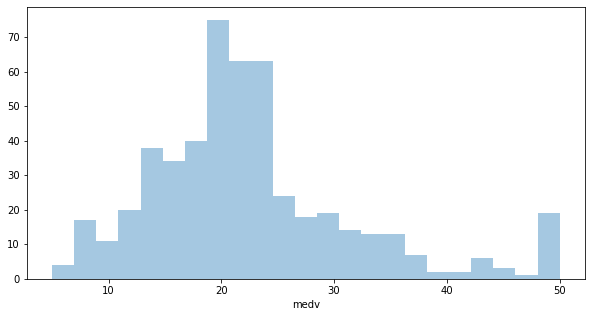

In [6]:
plt.figure(figsize = (10, 5))
sns.distplot(data["medv"], kde= False)

<p>we can see that the value 50.000 represents an outlier in our distribution.<p><br>
We can first check how many data points correspond to this value 

In [7]:
data[data["medv"] == 50].shape[0]

16

We can the proceed to remove these points, at least for the moment.

In [8]:
data = data[data["medv"] < 50]

<p>We can investigate now how the various predictors correlate with the target variable <em>medv</em><p>

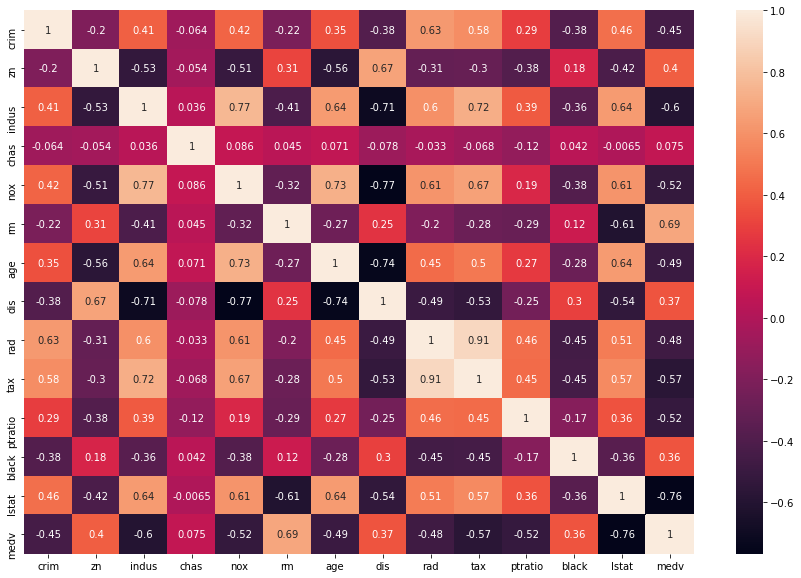

In [9]:
plt.figure(figsize = (15, 10))
sns.heatmap(data.corr(), annot=True)

<p>From the correlation matrix above, we expect that the predictors <em>indus</em>, <em>rm</em>, and <em>lstat</em> will induce a response on the target variable. Moreover, from domain knowledge we expect that also the variable <em>ptratio</em>, i.e. pupils to teacher ratio, will play a relevant role.</p>

We can ispect a few scatter plots to convince ourselves of the relation

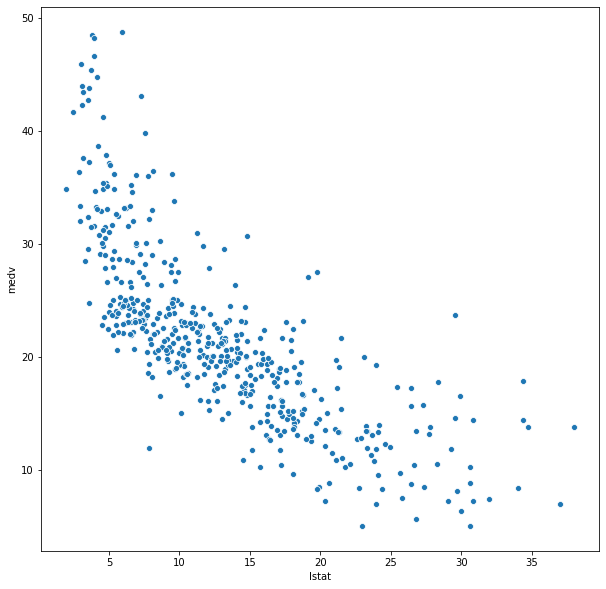

In [10]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x = "lstat", y = "medv", data = data)

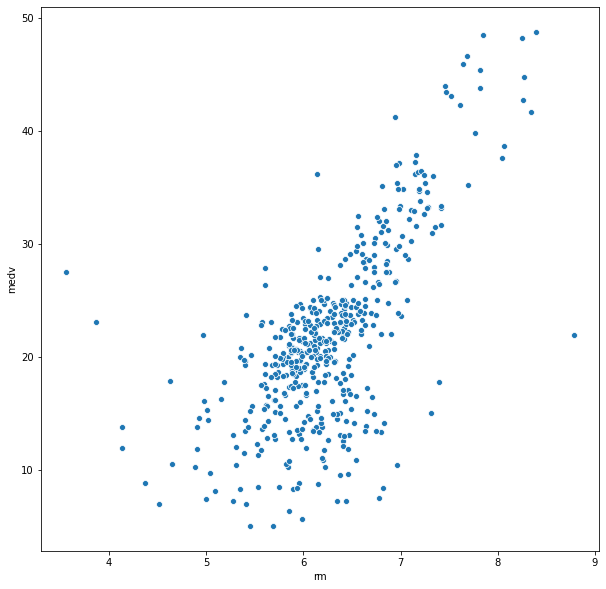

In [11]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x = "rm", y = "medv", data = data)

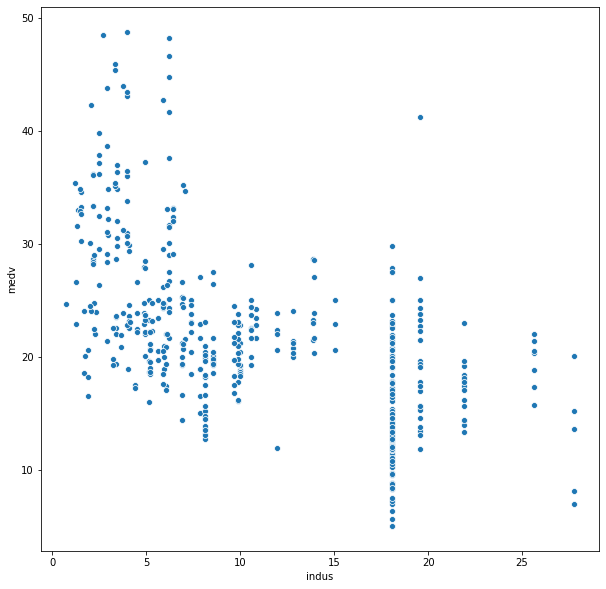

In [12]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x = "indus", y = "medv", data = data)

<p>We can see that the relation is less clear in the case of the descriptor <em>indus</em>.</p>

<h2>2. Linear Models</h2>

<p>We will now implement a <b>linear model</b>, i.e. a model of the form</p><br>
$Y = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} + \cdots \beta_{n}X_{n}$
<p>where $n$ is the number of features or descriptors.</p><br>
From a statistical learning point of view, we assume that, modulo errors, the above model describes the dependence between the random variables $X_{1}, X_{2},\ldots,X_{n}$ and the random variable $Y$. <br>
In this sense, we consider the quantities $\beta_{i}$ as <b>fixed but unknown</b> parameters of our model, which we want to estimate from a random sample of the variables $X_{1}, X_{2},\ldots,X_{n},Y$, i.e. our training dataset.<br> 
We can then apply the machinery of hypothesis testing to investigate the accuracy of the predicted values for these parameters.<br><br>

In the following, we will divide our dataset in train and test, and use the later for final evaluation.</p>

In [13]:
##Extract dependent and independent variables

y = data["medv"]
X = data.drop("medv", axis = 1)

In [14]:
## Split dataset as train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

We first scale and center the dataset

In [15]:
scaler = StandardScaler()
X_train_l = scaler.fit_transform(X_train)
y_train_l = y_train - np.average(y_train) ##Centering the target data

We can now then use statsmodel to perform an (ordinary) multiple linear regression

In [16]:
X_train_l = sm.add_constant(X_train_l)
model = sm.OLS(y_train_l, X_train_l)
results = model.fit()

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     97.56
Date:                Mon, 19 Oct 2020   Prob (F-statistic):          5.16e-112
Time:                        16:18:26   Log-Likelihood:                -1078.7
No. Observations:                 392   AIC:                             2185.
Df Residuals:                     378   BIC:                             2241.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.275e-15      0.195   1.68e-14      1.000      -0.383       0.383
x1            -0.9579      0.259     -3.692      0.000      -1.468      -0.448
x2             0.7431      0.294      2.526      0.012       0.165       1.322
x3            -0.3462      0.389     -0.889      0.374      -1.112       0.419
x4            -0.0291      0.204     -0.143      0.887      -0.430       0.372
x5            -1.3278      0.416     -3.193      0.002      -2.145      -0.510
x6             2.2914      0.263      8.711      0.000       1.774       2.809
x7            -0.4970      0.337     -1.476      0.141      -1.159       0.165
x8            -2.5447      0.389     -6.542      0.000      -3.310      -1.780
x9             2.3247      0.514      4.525      0.000       1.315       3.335
x10           -2.4852      0.562     -4.422      0.000      -3.590      -1.380
x11           -1.8576      0.253     -7.334      0.000      -2.356      -1.360
x12            0.7729      0.232      3.326      0.001       0.316       1.230
x13           -2.7202      0.342     -7.946      0.000      -3.393      -2.047
==============================================================================
Omnibus:                       65.689   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.733
Skew:                           0.959   Prob(JB):                     4.49e-26
Kurtosis:                       4.863   Cond. No.                         9.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<p>The table above contains information, which we can use to answer the following questions: <p>
    <ul>
        <li> Is there a relationship between at least one of the descriptors $X_{1},\ldots,X_{n}$ and the variable Y?</li>
        <li> Which feature is worth keeping?</li>
    </ul>

<p>The answer to the first question is provided by the value of the F-statistics: since it is quite large, we can reject the hypothesis of no relation between the descriptors and the target variable.</p><br>
<p>Regarding the second answer, there are various techniques we can use to identify the features to keep. In the following, we will use <b>backward elimination</b>. Namely, we eliminate a feature if with maximum p-value such that it is above a threshold (in this case 0.05); after each elimination, we fit the model again.</p> 

In [18]:
##List of the column indices to keep

features_keep = list(range(X_train_l.shape[1]))

In [19]:
p_val = 1
while p_val > 0.05:
    model = sm.OLS(y_train_l, X_train_l[:, features_keep])
    results = model.fit()
    ##Find the index corresponding to the maximum p-value
    idx_max = np.argmax(results.pvalues)
    p_val = results.pvalues[idx_max]
    ##In case the p-value is above the threshold, remove the corresponding feature
    if (p_val > 0.05):
        features_keep.pop(idx_max)

In [20]:
model = sm.OLS(y_train_l, X_train_l[:, features_keep])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   medv   R-squared (uncentered):                   0.769
Model:                            OLS   Adj. R-squared (uncentered):              0.763
Method:                 Least Squares   F-statistic:                              126.9
Date:                Mon, 19 Oct 2020   Prob (F-statistic):                   7.81e-115
Time:                        16:18:26   Log-Likelihood:                         -1080.2
No. Observations:                 392   AIC:                                      2180.
Df Residuals:                     382   BIC:                                      2220.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.9582      0.259     -3.706      0.000      -1.466      -0.450
x2             0.8061      0.291      2.770      0.006       0.234       1.378
x3            -1.6082      0.376     -4.274      0.000      -2.348      -0.868
x4             2.2283      0.255      8.738      0.000       1.727       2.730
x5            -2.3126      0.363     -6.372      0.000      -3.026      -1.599
x6             2.4922      0.492      5.062      0.000       1.524       3.460
x7            -2.6830      0.512     -5.242      0.000      -3.689      -1.677
x8            -1.9346      0.247     -7.829      0.000      -2.420      -1.449
x9             0.7576      0.232      3.272      0.001       0.302       1.213
x10           -2.9143      0.319     -9.135      0.000      -3.541      -2.287
==============================================================================
Omnibus:                       64.948   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.831
Skew:                           0.956   Prob(JB):                     1.91e-25
Kurtosis:                       4.821   Cond. No.                         7.66
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<p>From the table above we see that the F-statistics has increased, while the $R^{2}$-score and its adjusted version are basically constant. We will then keep our reduced model.</p>

<h2>3. Model Evaluation</h2><br>
<p>We can now evaluate the model built in the previous section on our test dataset, to probe its generalization error.<br>
First, we need to apply the same scaling processing to the test dataset.</p>

In [21]:
##We drop the first entry in features_keep, which corresponds to the intercept
columns_to_keep = [X_train.columns[i-1] for i in features_keep[1:]]
X_train_l = X_train[columns_to_keep]
X_test_l = X_test[columns_to_keep]

In [22]:
##We will use Linear Regression from Scikit-learn which natively fits into a pipeline for cross-validation

regressor = LinearRegression()
scaler = StandardScaler()
model = Pipeline([("scaler", scaler), 
                  ("regressor", regressor)])

<p>We can now compute the $R^{2}$-score using a 5-fold cross-validation.<br>
To this aim, we will use a TransformedTargetRegressor class, which allows to sytematically transform the target values.</p>

In [23]:
transformer = StandardScaler(with_std= False)

model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )

In [24]:
cv = KFold(n_splits= 5, shuffle = True)
score = cross_validate(model_t, X_train_l, y_train, cv = cv, scoring='r2')
print("The average R^2-score is: ", np.average(score["test_score"]))

The average R^2-score is:  0.7325901360728662


<p>As a sanity check, we can fit a linear model using all the features, and compute the $R^{2}$-score using cross-validation: if everything goes according to plan, we should get a lower value/similar value than our reduced model </p> 

In [25]:
cv = KFold(n_splits= 5, shuffle = True)
score = cross_validate(model_t, X_train, y_train, cv = cv, scoring='r2')
print("The average R^2-score is: ", np.average(score["test_score"]))

The average R^2-score is:  0.7310361563329005


<p>As expected, the reduced model performs similarly, but with less indipendent variables, hence it is preferable.</p>

<h2>4.Linear models with Interactions</h2>

<p>The model considered until now is linear (actually affine) in its variable.<br>
    What happens if we introduce interactions to capture some possible non-linearities? Would this increase its performances?</p>

In [26]:
##We can quickly introduce interactions, and check the averaged R^2-score for different degrees
degrees = [2, 3, 4, 5]
for deg in degrees:
    interactions = PolynomialFeatures(degree = deg)
    regressor = LinearRegression()
    scaler = StandardScaler()
    model = Pipeline([("scaler", scaler), 
                      ("interactions", interactions),
                      ("regressor", regressor)])
    transformer = StandardScaler(with_std= False)
    model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
    cv = KFold(n_splits= 5, shuffle = True)
    score = cross_validate(model_t, X_train_l, y_train, cv = cv, scoring='r2')
    print("The average R^2-score for the model with degree ", deg, "interactions is: ", np.average(score["test_score"]))

The average R^2-score for the model with degree  2 interactions is:  0.770182291614585
The average R^2-score for the model with degree  3 interactions is:  -16.198267566441338
The average R^2-score for the model with degree  4 interactions is:  -239.1297467499939
The average R^2-score for the model with degree  5 interactions is:  -369.8762137066767


<p>Notice that the introduction of degree 2 interactions improves the $R^{2}$-score considerably, while higher-order degrees fail miserably.</p>

<h2>5.Other Models: KNN and Random Forest</h2>

<p>How would other models compare to our linear model with interactions, using the same features?<br>
We will briefly test two non-parametric regression models, namely KNN and Random Forest.<br><br>
We begin with KNN, selecting different numbers of neighbours.</p>

In [27]:
neighbors = [2, 3, 4, 5, 6, 8, 10]
for n in neighbors:
    regressor = KNeighborsRegressor(n_neighbors = n)
    scaler = StandardScaler()
    model = Pipeline([("scaler", scaler), 
                      ("regressor", regressor)])
    transformer = StandardScaler(with_std= False)
    model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
    cv = KFold(n_splits= 5, shuffle = True)
    score = cross_validate(model_t, X_train_l, y_train, cv = cv, scoring='r2')
    print("The average R^2-score for the model with ", n, "neighbors is: ", np.average(score["test_score"]))

The average R^2-score for the model with  2 neighbors is:  0.7616470601798401
The average R^2-score for the model with  3 neighbors is:  0.7922557799366492
The average R^2-score for the model with  4 neighbors is:  0.7902534349428906
The average R^2-score for the model with  5 neighbors is:  0.8004967810603143
The average R^2-score for the model with  6 neighbors is:  0.7926108377007977
The average R^2-score for the model with  8 neighbors is:  0.7890250285857944
The average R^2-score for the model with  10 neighbors is:  0.774520179122677


<p>We can see that a KNN regressor in this case performs a bit worse than our linear model with interactions.<br><br>
We can continue to investigate the performances of a Random Forest Regressor.</p>

In [28]:
n_estimators = [10, 20, 30, 50, 100, 150, 200, 300]
for n in n_estimators:
    regressor = RandomForestRegressor(n_estimators = n)
    scaler = StandardScaler()
    model = Pipeline([("scaler", scaler), 
                      ("regressor", regressor)])
    transformer = StandardScaler(with_std= False)
    model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
    cv = KFold(n_splits= 5, shuffle = True)
    score = cross_validate(model_t, X_train_l, y_train, cv = cv, scoring='r2')
    print("The average R^2-score for the model with ", n, "estimators is: ", np.average(score["test_score"]))

The average R^2-score for the model with  10 estimators is:  0.8032666572694293
The average R^2-score for the model with  20 estimators is:  0.8147458838526722
The average R^2-score for the model with  30 estimators is:  0.8347328858644281
The average R^2-score for the model with  50 estimators is:  0.8264193472073462
The average R^2-score for the model with  100 estimators is:  0.8334688365541174
The average R^2-score for the model with  150 estimators is:  0.8394478286242292
The average R^2-score for the model with  200 estimators is:  0.8463954443768188
The average R^2-score for the model with  300 estimators is:  0.8319495153786651


<p>We can see that the Random Forest Regressor with 30-100 estimators has good performances, as measured by the $R^{2}$-score.<br><br>
We can also consider a model using all the features.</p>

In [29]:
n_est = 50
regressor = RandomForestRegressor(n_estimators = n_est)
scaler = StandardScaler()
model = Pipeline([("scaler", scaler), 
                  ("regressor", regressor)])
transformer = StandardScaler(with_std= False)
model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
cv = KFold(n_splits= 5, shuffle = True)
score = cross_validate(model_t, X_train, y_train, cv = cv, scoring='r2')
print("The average R^2-score for the model with ", n_est, "estimators is: ", np.average(score["test_score"]))

The average R^2-score for the model with  50 estimators is:  0.8420793606193271


<p>As expected, the model performs slightly worse.</p>

<h2>6.Learning Curves</h2>

<p>To understand better the performance of our models, in particular the bias-variance trade-off, we can plot the learning curves, which show training and validation error corresponding to different training dataset sizes.</p> 

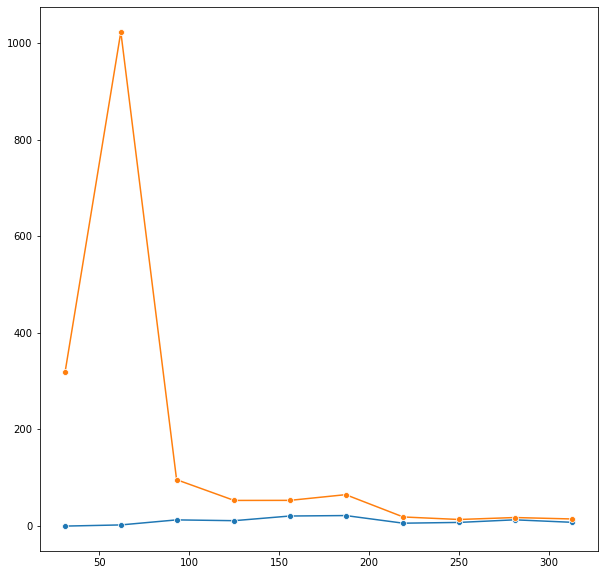

In [30]:
regressor = LinearRegression()
interactions = PolynomialFeatures(degree = 2)
scaler = StandardScaler()
model = Pipeline([("scaler", scaler), 
                  ("interactions", interactions),
                  ("regressor", regressor)])
transformer = StandardScaler(with_std= False)
model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
cv = KFold(n_splits= 5, shuffle = True)

n_sizes, train_scores, test_scores = learning_curve(model_t, X_train_l, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = cv, scoring= "neg_mean_squared_error")

plt.figure(figsize = (10, 10))
sns.lineplot(n_sizes, np.average(train_scores, axis = 1) * (-1), marker= 'o')
sns.lineplot(n_sizes, np.average(test_scores, axis = 1) * (-1), marker = 'o')

<p>From the learning curves above, it seems  that Linear Regression with interactions is performing really well. Wait, notice the scale!
Indeed, the test error at the beginning is really high, giving the impression of almost no variance, and very low bias.<br>
We can plot the curves again, focussing on the last points.</p>

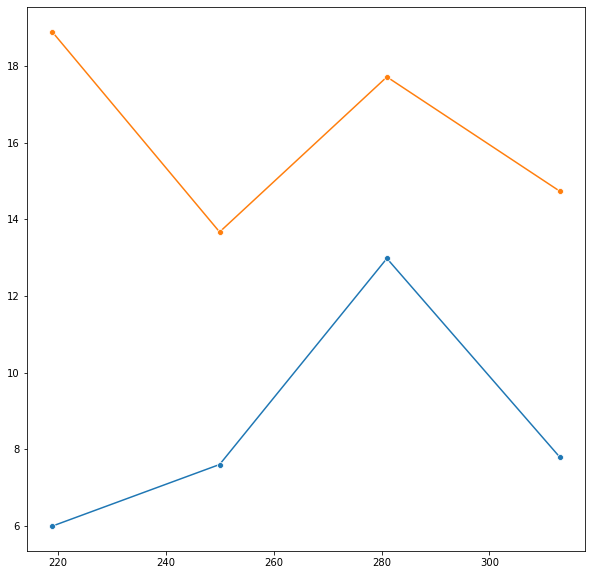

In [31]:
plt.figure(figsize = (10, 10))
sns.lineplot(n_sizes[6:], np.average(train_scores, axis = 1)[6:] * (-1), marker= 'o')
sns.lineplot(n_sizes[6:], np.average(test_scores, axis = 1)[6:] * (-1), marker = 'o')

<p>More reasonably, the plot above shows that the validation error gets close to the training error, still preserving an expected gap.<br><br>
We can plot learning curves for the KNN and Random Forest model as well.</p>

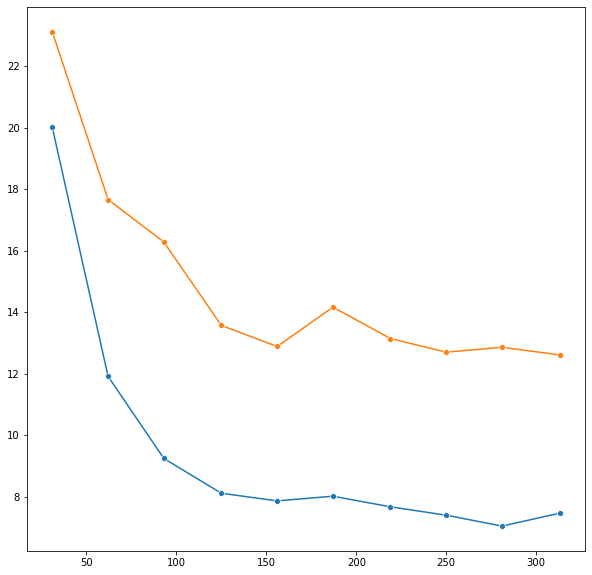

In [32]:
regressor = KNeighborsRegressor(n_neighbors = 4)
scaler = StandardScaler()
model = Pipeline([("scaler", scaler), 
                  ("regressor", regressor)])
transformer = StandardScaler(with_std= False)
model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
cv = KFold(n_splits= 5, shuffle = True)

n_sizes, train_scores, test_scores = learning_curve(model_t, X_train_l, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = cv, scoring= "neg_mean_squared_error")

plt.figure(figsize = (10, 10))
sns.lineplot(n_sizes, np.average(train_scores, axis = 1) * (-1), marker= 'o')
sns.lineplot(n_sizes, np.average(test_scores, axis = 1) * (-1), marker = 'o')

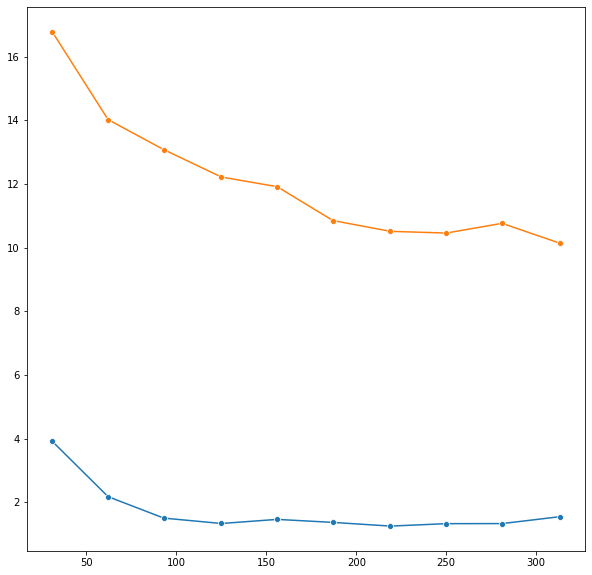

In [33]:
regressor = RandomForestRegressor(n_estimators = 50, max_depth = None)
scaler = StandardScaler()
model = Pipeline([("scaler", scaler), 
                  ("regressor", regressor)])
transformer = StandardScaler(with_std= False)
model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
cv = KFold(n_splits= 5, shuffle = True)

n_sizes, train_scores, test_scores = learning_curve(model_t, X_train_l, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = cv, scoring= "neg_mean_squared_error")

plt.figure(figsize = (10, 10))
sns.lineplot(n_sizes, np.average(train_scores, axis = 1) * (-1), marker= 'o')
sns.lineplot(n_sizes, np.average(test_scores, axis = 1) * (-1), marker = 'o')

<p>We can see that the model based on KNN has lower variance, but higher bias.<br>
   On the other hand, the model based on Random Forest has higher variance, but lower bias.<br><br>
We can try to reduce the variance for the Random Forest model by fixing the maximum depth of the leaf of each decision tree.
</p>

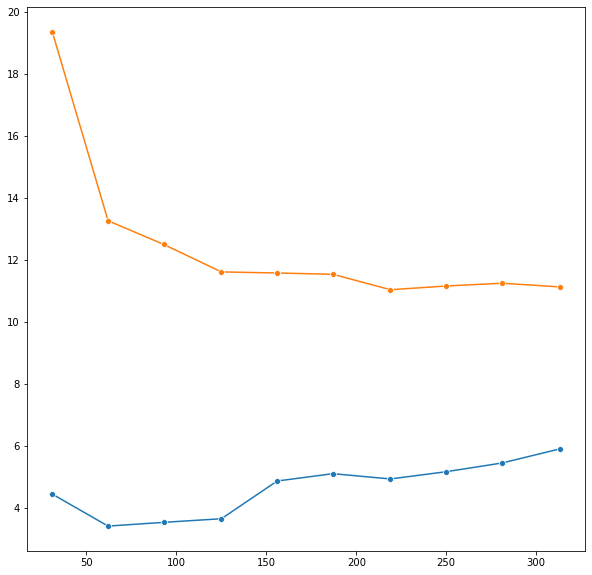

In [34]:
regressor = RandomForestRegressor(n_estimators = 50, max_depth = 4)
scaler = StandardScaler()
model = Pipeline([("scaler", scaler), 
                  ("regressor", regressor)])
transformer = StandardScaler(with_std= False)
model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
cv = KFold(n_splits= 5, shuffle = True)

n_sizes, train_scores, test_scores = learning_curve(model_t, X_train_l, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = cv, scoring= "neg_mean_squared_error")

plt.figure(figsize = (10, 10))
sns.lineplot(n_sizes, np.average(train_scores, axis = 1) * (-1), marker= 'o')
sns.lineplot(n_sizes, np.average(test_scores, axis = 1) * (-1), marker = 'o')

<p>We can see that Linear Regression with interactions and Random Forest have similar performances, and similar training/validation error trends. We will prefer in this case Linear Regression for its simplicity.</p>

<h2>7.Final evaluation</h2>
<p>We can finally evaluate our models on the test dataset, to provide a final assessment of their performances.</p>

In [35]:
regressor = LinearRegression()
interactions = PolynomialFeatures(degree = 2)
scaler = StandardScaler()
model = Pipeline([("scaler", scaler), 
                  ("interactions", interactions),
                  ("regressor", regressor)])
model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
model_t.fit(X_train_l, y_train)
y_pred = model_t.predict(X_test_l)
score_mean = mean_squared_error(y_test, y_pred)
score_r2 = r2_score(y_test, y_pred)

print("The mean squared error evaluated on the test dataset is: ", score_mean)
print("The R^{2} evaluated on the test dataset is: ", score_r2)

The mean squared error evaluated on the test dataset is:  8.355183607269126
The R^{2} evaluated on the test dataset is:  0.8565455241365225


In [36]:
regressor = RandomForestRegressor(n_estimators = 50, max_depth = 4)

scaler = StandardScaler()
model = Pipeline([("scaler", scaler), 
                
                  ("regressor", regressor)])
model_t = TransformedTargetRegressor(regressor = model, transformer = transformer )
model_t.fit(X_train, y_train)
y_pred = model_t.predict(X_test)
score_mean = mean_squared_error(y_test, y_pred)
score_r2 = r2_score(y_test, y_pred)

print("The mean squared error evaluated on the test dataset is: ", score_mean)
print("The R^{2} evaluated on the test dataset is: ", score_r2)

The mean squared error evaluated on the test dataset is:  7.638842385812257
The R^{2} evaluated on the test dataset is:  0.8688447576774939
